In [2]:
import math
import numpy as np
import numba
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr
plt.rc('text', usetex=True)

# sys.path.insert(0,'../') #load the local version of vsdm

import vsdm
from vsdm.units import *
from vsdm.utilities import *
from vsdm import McalK

diffM, diffV = vsdm.testG_lm(5, -3, printout=False)
if np.abs(diffV) < 1e-14:
    print("testing 'spherical' and WignerG: PASS")
else:
    print("testing 'spherical' and WignerG: FAIL")
    print("check the version number for 'spherical', and run testD_lm()")
print("vsdm", vsdm.__version__)

testing 'spherical' and WignerG: PASS
vsdm 0.4.0


In [3]:
#pip install quaternionic
#pip install spherical

In [4]:
@numba.jit("double(int64,double)", nopython=True)
def fj2(nj, qLj):
    if qLj==0:
        if nj==1:
            return 1
        else:
            return 0
    qlp = np.abs(qLj)/np.pi
    # mathsinc(x) = np.sinc(x/pi)
    s_minus = np.sinc(0.5*(qlp - nj + 1))/(1 + (nj-1)/qlp)
    s_plus = np.sinc(0.5*(qlp - nj - 1))/(1 + (nj+1)/qlp)
    return (s_minus + s_plus)**2

# Long thin box limit: assuming that Lz > Lx,Ly,
# so the lowest excited states are nz=2, nz=3, with nx=ny=1.

@numba.jit("double(double[:],int64,double[:])", nopython=True)
def fs2_nz(Lvec, nz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
#     qL = qLx + qLy + qLz
    fx2 = fj2(1, qLx)
    fy2 = fj2(1, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

@numba.jit("double(double[:],int64[:],double[:])", nopython=True)
def fs2_nxyz(Lvec, n_xyz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    [nx, ny, nz] = n_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
    fx2 = fj2(nx, qLx)
    fy2 = fj2(ny, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2


# Cartesian version of fs2:
@numba.jit("double(double[:])", nopython=True)
def fs2_model4_cart(q_xyz):
    return fs2_nz(np.array([4/qBohr, 7/qBohr, 10/qBohr]), 2, q_xyz)


### Defining the function fs2(qSph) that ProjectFnlm will use as the input.
#   The function is decorated with symmetry identifiers (phi_even, phi_cyclic, etc)
#   This function is not a GaussianF instance, a sum of gaussians (is_gaussian==False) 

QMAX = 10*qBohr # Global value for q0=qMax for wavelets
Qdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
Vdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)


# @numba.jit("double(double[:])", nopython=True)
def fs2_model4(qSph):
    [q, theta, phi] = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    q_xyz = np.array([qx, qy, qz])
    Lvec = np.array([4/qBohr, 7/qBohr, 10/qBohr])
    return fs2_nz(Lvec, 2, q_xyz)
fs2_model4.is_gaussian = False
fs2_model4.z_even = True
fs2_model4.phi_even = True
fs2_model4.phi_cyclic = 2
fs2_model4.center_Z2 = True
fs2_model4.DeltaE = 4.03*eV


In [5]:
"""Read in gX and fs2 from CSV files."""

### MOMENTUM DISTRIBUTION EXAMPLE
QMAX = 10*qBohr # Global value for q0=qMax for wavelets

Qdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)

# # Read Fnlm from saved csv file...
fs2_csv = 'demo_fs2'
fs2 = vsdm.Fnlm(Qdict, f_type='fs2', use_gvar=False)
fs2.center_Z2 = True
fs2.importFnlm_csv('tools/demo/'+fs2_csv+'.csv')
print(fs2.basis)
print('t_eval:', fs2.t_eval)
print('nCoeffs = {}'.format(len(fs2.f_nlm.keys())))
print('DeltaE [eV]:', fs2_model4.DeltaE/eV)


### VELOCITY : USE SHM
### VELOCITY DISTRIBUTION EXAMPLE: SHM 

VMAX = 820.*km_s # Global value for v0=vMax for wavelets
Vbasis = dict(u0=VMAX, type='wavelet', uMax=VMAX)

"""Read from HDF5"""
gX_csv = 'SHM_v250'
gX = vsdm.Fnlm(Vbasis, f_type='gX', use_gvar=False)
gX.importFnlm_csv(''+gX_csv+'.csv')
print('gX: ellMax = {}     nCoeffs_v =  {}     nMax = {}'.format(gX.ellMax, 
    len(gX.f_nlm.keys()), gX.nMax))

#fs2['gX'] = gX # for convenience, in convergence testing  (Not sure why we need this. maybe later)

{'u0': 37289.47137978341, 'type': 'wavelet', 'uMax': 37289.47137978341}
t_eval: 0.30103516578674316
nCoeffs = 114688
DeltaE [eV]: 4.03
gX: ellMax = 32     nCoeffs_v =  33928     nMax = 7007


In [6]:
# Sorted
sume = {}
conv = {}
norm_fs2 = {}


norm_fs2 = fs2.f2nlm_norm()
print('energy ({})'.format(4.03), norm_fs2)   # What does this do?

sume = 0.
conv = []
# print('{}  \t{}  \t{}'.format('n,l,m', '\tf**2', '\tsum(f**2)'))
counter = 0  # just a stopper for the loop to avoid printing too much..
for key,value in fs2.getNLMpower().items():
    power = value/norm_fs2
    sume += power
    conv += [sume]
    counter=counter+1
    if counter <5:
        print('\t{}  \t{:.6G}  \t{}'.format(key, power, sume))

#print("The value of conv is",conv)   # Note that this gives the cumulative sum #Uncomment to view.

print("Now we do the l power.\n")



##########################

powerL = {}
sum_l = {}
conv_l = {}
p_l = {}


powerL = fs2.getLpower()
sum_l = 0.
conv_l = []
p_l = []
#print('{}:'.format(sI))
for key,power in powerL.items():
    power /= norm_fs2
    sum_l += power
    p_l += [[key, power]]
    conv_l += [sum_l]
    print('\t{}  \t{:.6G}  \t{}'.format(key, power, sum_l))

p_l = np.array(p_l)


energy (4.03) 0.00035193106325939673
	(4, 0, 0)  	0.381174  	0.3811735551851416
	(2, 0, 0)  	0.148552  	0.5297255902336228
	(4, 2, 0)  	0.138989  	0.6687141649805702
	(4, 4, 0)  	0.0298536  	0.6985677499200974
Now we do the l power.

	0  	0.642452  	0.642452056196576
	2  	0.245403  	0.8878546579982874
	4  	0.0840763  	0.9719309491323467
	6  	0.0224962  	0.9944271655591096
	8  	0.00473808  	0.9991652484962439
	10  	0.000746061  	0.9999113095269161
	12  	8.29472E-05  	0.9999942566992893
	14  	5.50427E-06  	0.9999997609737111
	16  	1.52271E-07  	0.9999999132448706
	18  	4.61979E-08  	0.9999999594427517
	20  	2.48034E-08  	0.9999999842461917
	22  	9.73675E-09  	0.9999999939829457
	24  	4.11004E-09  	0.9999999980929841
	26  	1.40724E-09  	0.9999999995002259
	28  	3.87034E-10  	0.9999999998872597
	30  	1.13087E-10  	1.0000000000003466


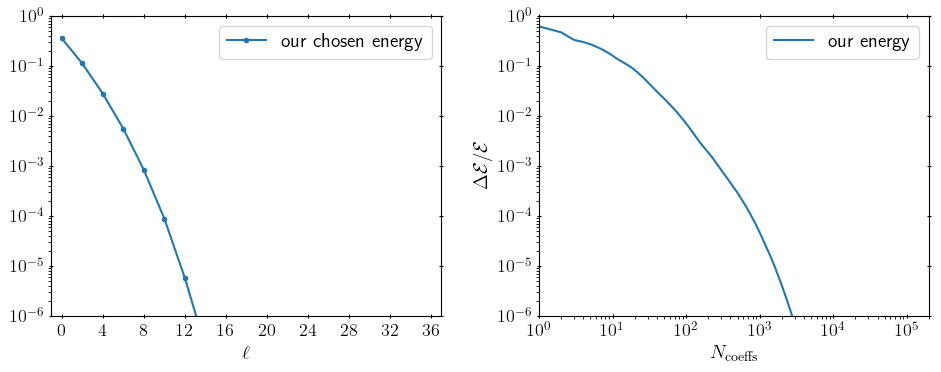

In [7]:
unisize = 3
fig = plt.figure(figsize=[1.3*unisize,unisize])
labels = 13
largelabels = 14
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')


ax.plot([l for l in powerL.keys()], 1-np.array(conv_l), 
        marker='.', label="our chosen energy")

ax.set_xlim([-1, 37])
ax.set_xticks([4*j for j in range(10)])
ax.set_ylim([1e-6, 1])
ax.set_xlabel(r'$\ell$', fontsize=largelabels, usetex=True)
# ax.set_ylabel(r'$\Delta\mathcal{E} / \mathcal{E}$', fontsize=largelabels, usetex=True)
ax.tick_params(axis='both', labelsize=labels, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)
ax.legend(loc='upper right', fontsize=largelabels)

ax2 = fig.add_axes([1.25,0,1,1], xscale='log', yscale='log')

ax2.plot([i+1 for i in range(len(conv))], 1-np.array(conv), 
         label="our energy")  #Recall conv counts the NLM power.

ax2.set_xlim([1, 2e5])
ax2.set_ylim([1e-6, 1])
ax2.set_xlabel(r'$N_{\rm coeffs}$', fontsize=largelabels, usetex=True)
ax2.set_ylabel(r'$\Delta\mathcal{E} / \mathcal{E}$', fontsize=largelabels, usetex=True)
ax2.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax2.legend(loc='upper right', fontsize=largelabels)

#fig.show()

In [8]:
## N_{coeffs} counts all tuples of (n,l,m)

In [9]:
powerLM = {}
sortlm = {}
sum_lm = {}
conv_lm = {}
p_nlm = {}
p_lm_n = {}
sump_lm_n = {}



powerLM = fs2.getLMpower()
sortlm = sorted(powerLM.items(), key=lambda z: z[1], reverse=True) # sorts the dictionary in descending order in values.

sum_lm = 0.
conv_lm = []
i = 0
print('{}:'.format("Our energy"))
for entry in sortlm:
    key, power = entry
    powerLM[key] = power
    power /= norm_fs2
    sum_lm += power
    conv_lm += [sum_lm]
    if i < 6:
        print('\t{}  \t{:.6G}  \t{}'.format(key, power, sum_lm))
    i += 1

p_nlm = fs2.getNLMpower(lMax=24)
p_lm_n = {}
sump_lm_n = {}
n_coeffs_n = 2**10
for lmP in sortlm[0:9]:
    (lm,P) = lmP
    plm = P
    p_lm_n[lm] = [p_nlm[(n, lm[0], lm[1])]/plm for n in range(n_coeffs_n)]  #very important. defines P_{lm}(n)
    sump = 0.0
    sump_lm_n[lm] = np.zeros(n_coeffs_n)
    for n in range(n_coeffs_n):
        sump += p_lm_n[lm][n]
        sump_lm_n[lm][n] = sump

Our energy:
	(0, 0)  	0.642452  	0.642452056196576
	(2, 0)  	0.197568  	0.8400197397592503
	(4, 0)  	0.0689423  	0.908962056732362
	(2, 2)  	0.0478349  	0.9567969749713998
	(4, 2)  	0.0130654  	0.9698624097626342
	(6, 0)  	0.0117365  	0.9815988952651789


In [10]:
### Do the same for gX. Look at P_{nlm}
powerLM_gX = gX.getLMpower()
sortlm_gX = sorted(powerLM_gX.items(), key=lambda z: z[1], reverse=True) # sorts the dictionary in descending order in values.



p_nlm_gX = gX.getNLMpower(lMax=24)
p_lm_n_gX = {}
sump_lm_n_gX = {}
n_coeffs_n = 2**10
for lmP in sortlm_gX[0:9]:
    (lm_gX,P_gX) = lmP
    plm_gX = P_gX
    p_lm_n_gX[lm_gX] = [p_nlm_gX[(n, lm_gX[0], lm_gX[1])]/plm_gX for n in range(n_coeffs_n)]  #very important. defines P_{lm}(n)
    sump_gX = 0.0
    sump_lm_n_gX[lm_gX] = np.zeros(n_coeffs_n)
    for n in range(n_coeffs_n):
        sump_gX += p_lm_n_gX[lm_gX][n]
        sump_lm_n_gX[lm_gX][n] = sump_gX

In [11]:
p_nlm_gX[(2, 0, 0)]

0.05819103810497862

In [12]:
sortlm_gX[0:9]

[((1, 0), 1.1093168234041522),
 ((0, 0), 1.07415665077766),
 ((2, 0), 0.3935080184609255),
 ((3, 0), 0.08469739070627144),
 ((4, 0), 0.013188848541232517),
 ((5, 0), 0.001629955809172459),
 ((6, 0), 0.0001757008607895696),
 ((7, 0), 2.393874493470837e-05),
 ((8, 0), 9.149127842549999e-06)]

In [13]:
#As I understand it, n is not restricted by lm values. So we just choose 2**10, and find P_{lm}(n) for each of
# those coefficients. We could have gone higher if we wanted to.

Text(0.97, 0.97, '$(0, 0)$')

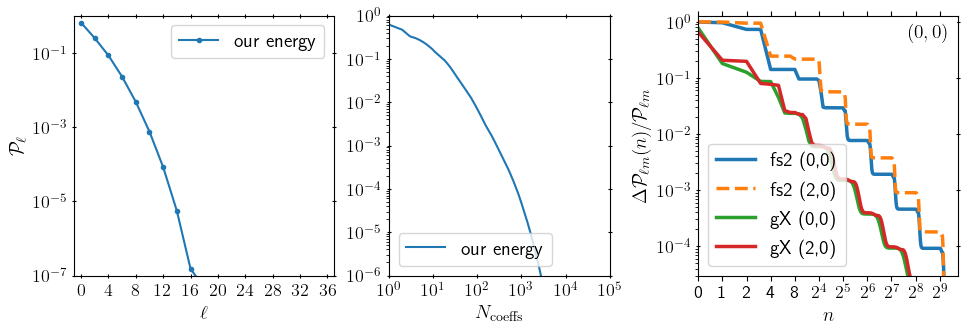

In [14]:
unisize = 2.6
fig = plt.figure(figsize=[1.*unisize,unisize])
labels = 13
fonts = 14

largelabels = 14
nsize = 2**10
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='log')
# for sI in fs2.keys():
#     ax.plot([l for l in powerL[sI].keys()], 1-np.array(conv_l[sI]), 
#             marker='.',label=sI)

ax.plot(p_l[:,0],p_l[:,1], 
        marker='.', label="our energy")

ax.set_xlim([-1, 37])
ax.set_xticks([4*j for j in range(10)])
ax.set_ylim([1e-7, 1])
ax.set_xlabel(r'$\ell$', fontsize=largelabels, usetex=True)
ax.set_ylabel(r'$\mathcal P_\ell$', fontsize=largelabels, usetex=True)
ax.tick_params(axis='both', labelsize=labels, direction='inout',
               right=True, top=True, labelleft=True, labelright=False,
               labelbottom=True, labeltop=False)
ax.legend(loc='upper right', fontsize=largelabels)
# ax.text(0.96, 0.04, r'$\vec{n}=(1,1,2)$', horizontalalignment='right',
#          verticalalignment='bottom', fontsize=fonts, 
#          color='black', backgroundcolor='white',
#          transform=ax.transAxes, usetex=True)

ax2 = fig.add_axes([1.21,0,0.85,1], xscale='log', yscale='log')

ax2.plot([i+1 for i in range(len(conv))], 1-np.array(conv), 
         label="our energy")
ax2.set_xlim([1, 1e5])
ax2.set_ylim([1e-6, 1])
ax2.set_xticks([10**j for j in range(6)])
ax2.set_xlabel(r'$N_{\rm coeffs}$', fontsize=largelabels, usetex=True)
ax2.tick_params(axis='both', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax2.legend(loc='lower left', fontsize=largelabels)


lm_B = (2, 0)
lm_A = (0, 0)
# lm_C = (4, 4)

ax3 = fig.add_axes([2.4,0,1,1], xscale='log', yscale='log')
nlist0 = [0.5]+[n for n in range(1,nsize)]
# for lbl in p_lm_n.keys():
#     if lbl != lm_A and lbl != lm_B and lbl != lm_C:
#         ax3.plot(nlist0, 1-sump_lm_n[lbl], color='gray')

ax3.plot(nlist0, 1-sump_lm_n[lm_A], linewidth=2.5,
         label='fs2 (0,0)')

ax3.plot(nlist0, 1-sump_lm_n[lm_B], linewidth=2.5,
         linestyle='dashed',label="fs2 (2,0)")

ax3.plot(nlist0, 1-sump_lm_n_gX[lm_A], linewidth=2.5,
         label="gX (0,0)")

ax3.plot(nlist0, 1-sump_lm_n_gX[lm_B], linewidth=2.5,
         label="gX (2,0)")



power2_plot = 10
ax3.set_xlim([1, 0.85*2**power2_plot])
ax3.set_ylim([3e-5, 1.3])
ax3.set_xticks([2**j for j in range(-1,power2_plot)], 
               labels=(["0"]+[str(int(2**j)) for j in range(4)] 
                       + [r"$2^{}$".format(j) for j in range(4, power2_plot)])
              )
ax3.set_xlabel(r'$n$', fontsize=largelabels, usetex=True)
ax3.set_ylabel(r'$\Delta \mathcal{P}_{\ell m}(n) / \mathcal{P}_{\ell m}$', 
               fontsize=largelabels, usetex=True)
ax3.tick_params(axis='x', labelsize=labels, direction='out',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax3.tick_params(axis='x', which='minor', bottom=False)
ax3.tick_params(axis='y', labelsize=labels, direction='inout',
                right=True, top=True, labelleft=True, labelright=False,
                labelbottom=True, labeltop=False)
ax3.legend(loc='lower left', fontsize=largelabels)
ax3.text(0.97, 0.97, r'${}$'.format(lm_A), horizontalalignment='right',
         verticalalignment='top', fontsize=fonts, 
         color='black', backgroundcolor='white',
         transform=ax3.transAxes, usetex=True)

# plt.savefig('out/fs2_convergence.pdf', format="pdf", bbox_inches='tight')


#fig.show()

Our energy actually is for the fs2 here.
See figure 7 in Ben's paper to understand these plots.

## Ok it looks like I can take $n_q = 2^8 - 1 = 255$ and $n_v = 2^6-1 = 63$, and I will take a few more $l$ so $l = 16$ to be good.

## Now let's look at I and K matrices.

In [15]:
#flabel = 's1'

gX_eg = gX
fs2_eg = fs2[flabel]

ellMax = 16
nvMax = 163
nqMax = 255
print(ellMax, nvMax, nqMax)

NameError: name 'flabel' is not defined

In [16]:
"""Comprehensive mI calculation for larger list of DM masses:

Following the results from 'Convergence', use a smaller ellMax and nMax:
"""

#We copy-paste this from before.
QMAX = 10*qBohr # Global value for q0=qMax for wavelets
Qbasis = dict(u0=QMAX, type='wavelet', uMax=QMAX)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
Vbasis = dict(u0=VMAX, type='wavelet', uMax=VMAX)


ellMax = 16
nvMax = 163
nqMax = 255


# ls10 = [1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9]
# p10 = [1, 10, 100]
#ls10 = [1]
#p10 = [10]
#mXlist = np.array([p*m for p in p10 for m in ls10])
# mXlist = mXlist[0:25]

"""Check the evaluation time for mcalI:"""
mI = {}
modelsDM = []
t0 = time.time()

fn = (0,0)   # FDM^2 ~ q^0 v^0


mX = 10
dmModel = dict(mX=mX*MeV, fdm=fn, mSM=mElec, DeltaE=4.03*10**(-6)*MeV)


mI[(mX, fn)] = vsdm.McalI(Vbasis, Qbasis, dmModel, 
                                      mI_shape=(ellMax+1, nvMax+1,nqMax+1), 
                                      center_Z2=True, 
                                      use_gvar=False, do_mcalI=True)
print((mX, fn), ": ", mI[(mX, fn)].t_eval)

tEvalI = time.time() - t0

(10, (0, 0)) :  48.143600940704346


In [17]:
mI

{(10, (0, 0)): <vsdm.matrixcalc.McalI at 0x18d0a8670>}

In [18]:
np.shape(mI[(mX,fn)].mcalI)  # I thought it would get rid of odd l but it looks like they are still there?

(17, 164, 256)

/var/folders/xm/dgywcqjd46l1x_7k4knjbbxm0000gn/T/ipykernel_3370/2607571143.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(mI[mX,fn].mcalI[0][0:128, 0:128]), cmap='viridis')
/var/folders/xm/dgywcqjd46l1x_7k4knjbbxm0000gn/T/ipykernel_3370/2607571143.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(mI[mX,fn].mcalI[0][0:128, 0:128]), cmap='viridis')


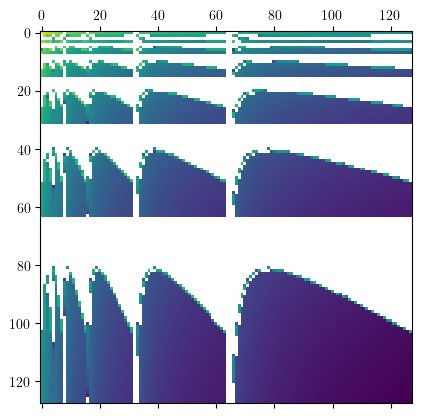

In [19]:
plt.matshow(np.log10(mI[mX,fn].mcalI[0][0:128, 0:128]), cmap='viridis')

In [20]:
## FOr now I will not worry about saving the I matrix. But let's think about that later.

## Calculate Partial K matrix from I matrix.

In [21]:
##helper cell
for key in mI.keys():
    print("mX is",key[0])
    print("fn is",key[1])
    
    mX 

mX is 10
fn is (0, 0)


In [22]:
gX.ellMax

32

In [23]:
mI[(10,(0,0))].mcalI

array([[[ 1.96020510e+02,  9.43548088e+01,  5.55681834e+01, ...,
          6.53552829e-02,  6.51049772e-02,  6.48606069e-02],
        [-2.94351645e+01,  3.12522577e+01,  4.99171016e+00, ...,
         -2.47019751e-02, -2.46073684e-02, -2.45150051e-02],
        [-1.57874403e+01, -2.36580334e+01, -9.19044690e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.59026150e-02, -9.49893908e-02, -2.10207715e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [24]:
t0 = time.time()
rates = {}
mK = {}
print('\t tEval[K]:')
for key in mI.keys():
    mX = key[0]
    fn = key[1]
rates = vsdm.RateCalc(gX, fs2, mI[(mX,fn)],use_gvar=False, sparse=False,lmod=2)

k_obj = McalK(ellMax,lmod=1)   # here we can also call mcalK directly to find K_vec directly if we decide to not use RateCalc object.
K_vec = k_obj.getK(gX, fs2, mI[(mX,fn)])

print((mX,fn),": ", rates.t_eval)
tEvalR = time.time() - t0

	 tEval[K]:
(10, (0, 0)) :  0.41612696647644043


In [25]:
np.nonzero(K_vec)

(array([   0,   22,   24,  124,  126,  128,  370,  372,  374,  376,  824,
         826,  828,  830,  832, 1550, 1552, 1554, 1556, 1558, 1560, 2612,
        2614, 2616, 2618, 2620, 2622, 2624, 4074, 4076, 4078, 4080, 4082,
        4084, 4086, 4088, 6000, 6002, 6004, 6006, 6008, 6010, 6012, 6014,
        6016]),)

### Apply rotations

In [26]:
diffM, diffV = vsdm.testG_lm(5, -3, printout=False)
if np.abs(diffV) < 1e-14:
    print("testing 'spherical' and WignerG: PASS")
else:
    print("testing 'spherical' and WignerG: FAIL")
    print("check the version number for 'spherical', and run testD_lm()")

testing 'spherical' and WignerG: PASS


In [27]:
def getQ(theta, phi):
    axisphi = phi + np.pi/2 #stationary under R
    axR = theta/2 
    qr = np.cos(axR)
    qi = np.sin(axR) * np.cos(axisphi)
    qj = np.sin(axR) * np.sin(axisphi)
    qk = 0. 
    return quaternionic.array(qr, qi, qj, qk)

def ix_thetaphi(theta, phi):
    return thetaphilist.index((theta, phi))

In [28]:
rotationlist = []
rotationarray = []
thetaphilist = []


#### IMPORTANT : TO TAKE CARE OF SYMMETRY of detector for particle in a box, thake only phi = 0 to 90 deg.



for theta in range(0, 180, 2):
    rrow = []
    for phi in range(0, 90, 2):
        # for WignerG, want to apply the inverse of getQ.
        # getQ applied to vE moves vE from the z axis to the position (theta, phi). 
        # 1/getQ applied to the crystal does the same thing, 
        #     with vE -> (theta, phi) in the frame of the crystal.
        q = 1/getQ(theta * np.pi/180, phi * np.pi/180) 
        rrow += [q] 
        rotationlist += [q] 
        thetaphilist += [(theta, phi)]
    rotationarray += [rrow]

rotationarray = np.array(rotationarray)
# thetaphilist = np.array(thetaphilist)
np.shape(rotationarray)

(90, 45, 4)

In [29]:
t0 = time.time()
wG = vsdm.WignerG(ellMax, rotations=rotationlist, lmod=2)
tG = time.time() - t0
print(tG)
print(len(rotationlist))
print(tG/len(rotationlist))

8.625379085540771
4050
0.0021297232309977214


In [30]:
t0 = time.time()
mu_all = {}
rate_all = {}
rate_angavg = {}

mu_R_l = rates.mu_R_l(wG)     # gives rates for all rotations in rotationlist
rate_R = mu_R_l.sum(axis=1)
mu_all = mu_R_l
rate_all = rate_R
rate_angavg = rates.vecK[0] # the ell=0 component of vecK is the angular average
print('{}: <R> = {}'.format(key, rate_angavg))

tR = time.time() - t0
print(tR)
#print(tR/len(rate_R)/len(rates.keys()))

(10, (0, 0)): <R> = 0.49471714550834056
1.0701351165771484


t0 = time.time()
mu_all = {}
rate_all = {}
rate_angavg = {}
for key in rates.keys():
    mu_R_l = rates[key].mu_R_l(wG)
    rate_R = mu_R_l.sum(axis=1)
    mu_all[key] = mu_R_l
    rate_all[key] = rate_R
    rate_angavg[key] = rates[key].vecK[0] # the ell=0 component of vecK is the angular average
    print('{}: <R> = {}'.format(key, rate_angavg[key]))
tR = time.time() - t0
print(tR)
print(tR/len(rate_R)/len(rates.keys()))

In [31]:
r_avg_min_max = {}

rate_R = np.array(rate_all)
rate_avg = rate_angavg
least = rate_R.min()    # what does this return exactly?
greatest = rate_R.max() # what does this return exactly?
r_avg_min_max = [rate_avg, least, greatest]
print('{}: {:.4g}\t{:.4g}\t{:.4g}'.format((mX,fn), rate_avg, least/rate_avg, greatest/rate_avg))
    

(10, (0, 0)): 0.4947	0.8696	1.131


In [32]:
len(rate_all) ## What determines the length of rate_all?

4050

In [33]:
## Compute R(theta,phi)/<R> , this is rate_norm
rate_norm = {}

thetaphi_size = (np.shape(rotationarray)[0], np.shape(rotationarray)[1])
thetaphiarray = np.array(thetaphilist).reshape(thetaphi_size[0], thetaphi_size[1], 2)

rate_all = np.array(rate_all)
rate_array = rate_all.reshape(thetaphi_size)
rate_norm = rate_array/rate_angavg


In [34]:
np.shape(rate_norm)   # rate_norm is the "normalized" rate in (theta,phi) space

(90, 45)

In [39]:
## Now I write down a function to process the normalized rate into 7*7 = 49 bins of (cos theta, phi).
## It might have been better to just sample with cos theta from the beginning but that's fine.

costhetas = np.cos(thetaphiarray[:,0,0]*(2*np.pi)/360)
phi_array = thetaphiarray[0,:,1]*(2*np.pi)/360

ctheta, phigrid = np.meshgrid(costhetas,phi_array)

from scipy.stats import binned_statistic_dd


samples = np.array(list(zip(np.ravel(ctheta), np.ravel(phigrid))))
values = np.ravel(rate_norm,order='F')   # I want to ravel by changing cos theta first, then phi.
bins = [7,10] # number of bins along each dimension

binned_rates_on_sphere = binned_statistic_dd(samples, values, statistic='mean', bins=bins).statistic  #row is ctheta direction, col is phi direction.

In [42]:
binned_statistic_dd(samples, values, statistic='mean', bins=bins)

BinnedStatisticddResult(statistic=array([[1.09818097, 1.09728012, 1.09544846, 1.09289867, 1.09017381,
        1.08686413, 1.08360285, 1.08073805, 1.07853699, 1.0772999 ],
       [1.0381485 , 1.03451705, 1.02706573, 1.01655541, 1.00514064,
        0.99102675, 0.97687391, 0.96423107, 0.95439609, 0.94881925],
       [1.02338696, 1.01823451, 1.00760128, 0.99247886, 0.97589073,
        0.95515655, 0.93414579, 0.91518908, 0.9003348 , 0.89186837],
       [1.02030605, 1.01462985, 1.00289175, 0.98614933, 0.96771974,
        0.94459639, 0.92107912, 0.89978805, 0.88306291, 0.87351341],
       [1.02338696, 1.01823451, 1.00760128, 0.99247886, 0.97589073,
        0.95515655, 0.93414579, 0.91518908, 0.9003348 , 0.89186837],
       [1.0381485 , 1.03451705, 1.02706573, 1.01655541, 1.00514064,
        0.99102675, 0.97687391, 0.96423107, 0.95439609, 0.94881925],
       [1.09960594, 1.09874425, 1.09699223, 1.0945533 , 1.09194691,
        1.08878113, 1.08566164, 1.0829214 , 1.08081604, 1.07963274]]), bin_e

## Now that I know how to do one binned rate in full. Let's write down a code that will do for all models that I want.

In [36]:
import math
import numpy as np
import numba
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr
plt.rc('text', usetex=True)

# sys.path.insert(0,'../') #load the local version of vsdm

import vsdm
from vsdm.units import *
from vsdm.utilities import *
from vsdm import McalK

diffM, diffV = vsdm.testG_lm(5, -3, printout=False)
if np.abs(diffV) < 1e-14:
    print("testing 'spherical' and WignerG: PASS")
else:
    print("testing 'spherical' and WignerG: FAIL")
    print("check the version number for 'spherical', and run testD_lm()")
print("vsdm", vsdm.__version__)

testing 'spherical' and WignerG: PASS
vsdm 0.4.0


In [37]:
@numba.jit("double(int64,double)", nopython=True)
def fj2(nj, qLj):
    if qLj==0:
        if nj==1:
            return 1
        else:
            return 0
    qlp = np.abs(qLj)/np.pi
    # mathsinc(x) = np.sinc(x/pi)
    s_minus = np.sinc(0.5*(qlp - nj + 1))/(1 + (nj-1)/qlp)
    s_plus = np.sinc(0.5*(qlp - nj - 1))/(1 + (nj+1)/qlp)
    return (s_minus + s_plus)**2

# Long thin box limit: assuming that Lz > Lx,Ly,
# so the lowest excited states are nz=2, nz=3, with nx=ny=1.

@numba.jit("double(double[:],int64,double[:])", nopython=True)
def fs2_nz(Lvec, nz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
#     qL = qLx + qLy + qLz
    fx2 = fj2(1, qLx)
    fy2 = fj2(1, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2

@numba.jit("double(double[:],int64[:],double[:])", nopython=True)
def fs2_nxyz(Lvec, n_xyz, q_xyz):
    # q: the DM particle velocity (cartesian, lab frame)
    # L: the dimensions of the box
    # nz = 2, 3, 4... The final state. (n=1 defined as ground state)
    # fs2 is dimensionless
    # note: np.sinc(x/pi) = sin(x) / (x). Included in defs. of qL below
    [Lx, Ly, Lz] = Lvec
    [qx, qy, qz] = q_xyz
    [nx, ny, nz] = n_xyz
    qLx = Lx*qx
    qLy = Ly*qy
    qLz = Lz*qz
    fx2 = fj2(nx, qLx)
    fy2 = fj2(ny, qLy)
    fz2 = fj2(nz, qLz)
    return fx2*fy2*fz2


# Cartesian version of fs2:
@numba.jit("double(double[:])", nopython=True)
def fs2_model4_cart(q_xyz):
    return fs2_nz(np.array([4/qBohr, 7/qBohr, 10/qBohr]), 2, q_xyz)


### Defining the function fs2(qSph) that ProjectFnlm will use as the input.
#   The function is decorated with symmetry identifiers (phi_even, phi_cyclic, etc)
#   This function is not a GaussianF instance, a sum of gaussians (is_gaussian==False) 

QMAX = 10*qBohr # Global value for q0=qMax for wavelets
Qdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
Vdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)


# @numba.jit("double(double[:])", nopython=True)
def fs2_model4(qSph):
    [q, theta, phi] = qSph
    qx = q*math.sin(theta) * math.cos(phi)
    qy = q*math.sin(theta) * math.sin(phi)
    qz = q*math.cos(theta)
    q_xyz = np.array([qx, qy, qz])
    Lvec = np.array([4/qBohr, 7/qBohr, 10/qBohr])
    return fs2_nz(Lvec, 2, q_xyz)
fs2_model4.is_gaussian = False
fs2_model4.z_even = True
fs2_model4.phi_even = True
fs2_model4.phi_cyclic = 2
fs2_model4.center_Z2 = True
fs2_model4.DeltaE = 4.03*eV


In [38]:
#We copy-paste this from before.
QMAX = 10*qBohr # Global value for q0=qMax for wavelets
Qbasis = dict(u0=QMAX, type='wavelet', uMax=QMAX)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
Vbasis = dict(u0=VMAX, type='wavelet', uMax=VMAX)


ellMax = 16
nvMax = 163
nqMax = 255


"""Rotations"""
##For rotations
def getQ(theta, phi):
    axisphi = phi + np.pi/2 #stationary under R
    axR = theta/2 
    qr = np.cos(axR)
    qi = np.sin(axR) * np.cos(axisphi)
    qj = np.sin(axR) * np.sin(axisphi)
    qk = 0. 
    return quaternionic.array(qr, qi, qj, qk)

def ix_thetaphi(theta, phi):
    return thetaphilist.index((theta, phi))

rotationlist = []
rotationarray = []
thetaphilist = []


#### IMPORTANT : TO TAKE CARE OF SYMMETRY of detector for particle in a box, thake only phi = 0 to 90 deg.



for theta in range(0, 180, 2):
    rrow = []
    for phi in range(0, 90, 2):
        # for WignerG, want to apply the inverse of getQ.
        # getQ applied to vE moves vE from the z axis to the position (theta, phi). 
        # 1/getQ applied to the crystal does the same thing, 
        #     with vE -> (theta, phi) in the frame of the crystal.
        q = 1/getQ(theta * np.pi/180, phi * np.pi/180) 
        rrow += [q] 
        rotationlist += [q] 
        thetaphilist += [(theta, phi)]
    rotationarray += [rrow]

rotationarray = np.array(rotationarray)
# thetaphilist = np.array(thetaphilist)
np.shape(rotationarray)


t0 = time.time()
wG = vsdm.WignerG(ellMax, rotations=rotationlist, lmod=2)
tG = time.time() - t0
print(tG)
print(len(rotationlist))
print(tG/len(rotationlist))



7.92425799369812
4050
0.001956606912024227


In [39]:
## Import fs2 and SHM gX
"""Read in gX and fs2 from CSV files."""

### MOMENTUM DISTRIBUTION EXAMPLE
QMAX = 10*qBohr # Global value for q0=qMax for wavelets

Qdict = dict(u0=QMAX, type='wavelet', uMax=QMAX)

# # Read Fnlm from saved csv file...
fs2_csv = 'demo_fs2'
fs2 = vsdm.Fnlm(Qdict, f_type='fs2', use_gvar=False)
fs2.center_Z2 = True
fs2.importFnlm_csv('tools/demo/'+fs2_csv+'.csv')
print(fs2.basis)
print('t_eval:', fs2.t_eval)
print('nCoeffs = {}'.format(len(fs2.f_nlm.keys())))
print('DeltaE [eV]:', fs2_model4.DeltaE/eV)


### VELOCITY : USE SHM
### VELOCITY DISTRIBUTION EXAMPLE: SHM 

VMAX = 820.*km_s # Global value for v0=vMax for wavelets
Vbasis = dict(u0=VMAX, type='wavelet', uMax=VMAX)

"""Read from HDF5"""
gX_csv = 'SHM_v250'
gX = vsdm.Fnlm(Vbasis, f_type='gX', use_gvar=False)
gX.importFnlm_csv(''+gX_csv+'.csv')
print('gX: ellMax = {}     nCoeffs_v =  {}     nMax = {}'.format(gX.ellMax, 
    len(gX.f_nlm.keys()), gX.nMax))

#fs2['gX'] = gX # for convenience, in convergence testing  (Not sure why we need this. maybe later)

{'u0': 37289.47137978341, 'type': 'wavelet', 'uMax': 37289.47137978341}
t_eval: 0.3813350200653076
nCoeffs = 114688
DeltaE [eV]: 4.03
gX: ellMax = 32     nCoeffs_v =  33928     nMax = 7007


In [40]:
from scipy.stats import binned_statistic_dd


thetaphi_size = (np.shape(rotationarray)[0], np.shape(rotationarray)[1])
thetaphiarray = np.array(thetaphilist).reshape(thetaphi_size[0], thetaphi_size[1], 2)

costhetas = np.cos(thetaphiarray[:,0,0]*(2*np.pi)/360)
phi_array = thetaphiarray[0,:,1]*(2*np.pi)/360
    
ctheta, phigrid = np.meshgrid(costhetas,phi_array)

def binned_rate(mX,fn): # FDM^2 ~ q^n v^m
    mI = {}
    #modelsDM = []
    
    #fn = (0,0)   
    
    
    #mX = 10
    
    dmModel = dict(mX=mX*MeV, fdm=fn, mSM=mElec, DeltaE=4.03*10**(-6)*MeV)
    
    
    mI[(mX, fn)] = vsdm.McalI(Vbasis, Qbasis, dmModel, 
                                          mI_shape=(ellMax+1, nvMax+1,nqMax+1), 
                                          center_Z2=True, 
                                          use_gvar=False, do_mcalI=True)
    print((mX, fn), ": ", mI[(mX, fn)].t_eval)
    
    
    
    
    
    
    print('\t tEval[K]:')
    rates = vsdm.RateCalc(gX, fs2, mI[(mX,fn)],use_gvar=False, sparse=False,lmod=2)
    
    print((mX,fn),": ", rates.t_eval)
    
    
    
    mu_R_l = rates.mu_R_l(wG)     # gives rates for all rotations in rotationlist
    rate_R = mu_R_l.sum(axis=1)
    mu_all = mu_R_l
    rate_all = rate_R
    rate_angavg = rates.vecK[0] # the ell=0 component of vecK is the angular average
    
    
    
    
    
    rate_R = np.array(rate_all)
    rate_avg = rate_angavg
    least = rate_R.min()    # what does this return exactly?
    greatest = rate_R.max() # what does this return exactly?
    r_avg_min_max = [rate_avg, least, greatest]
    print('{}: {:.4g}\t{:.4g}\t{:.4g}'.format((mX,fn), rate_avg, least/rate_avg, greatest/rate_avg))
    
    
    
    ## Compute R(theta,phi)/<R> , this is rate_norm
    
    
    rate_all = np.array(rate_all)
    rate_array = rate_all.reshape(thetaphi_size)
    rate_norm = rate_array/rate_angavg
    
    
    ## Now I write down a function to process the normalized rate into 7*7 = 49 bins of (cos theta, phi).
    ## It might have been better to just sample with cos theta from the beginning but that's fine.
    

    
    samples = np.array(list(zip(np.ravel(ctheta), np.ravel(phigrid))))
    values = np.ravel(rate_norm,order='F')   # I want to ravel by changing cos theta first, then phi.
    bins = [7,7] # number of bins along each dimension
    
    binned_rates_on_sphere = binned_statistic_dd(samples, values, statistic='mean', bins=bins).statistic  #row is ctheta direction, col is phi direction.
    # I think I should use "mean" statistic here.
    return binned_rates_on_sphere

In [41]:
mX = 100 # in MeV
fn = (0,0)
binned_rate(mX,fn)

(100, (0, 0)) :  67.74937796592712
	 tEval[K]:
(100, (0, 0)) :  0.3511800765991211
(100, (0, 0)): 0.07427	0.9056	1.126


array([[1.08900377, 1.08822381, 1.08686996, 1.08496182, 1.08295376,
        1.08137383, 1.08033865],
       [1.01680062, 1.01300766, 1.00629974, 0.99658595, 0.98606681,
        0.977579  , 0.97192233],
       [0.99487248, 0.98915336, 0.97892104, 0.96385669, 0.94726172,
        0.93367154, 0.9245247 ],
       [0.98915575, 0.9827565 , 0.97126008, 0.95423586, 0.93536961,
        0.9198401 , 0.90935257],
       [0.99487248, 0.98915336, 0.97892104, 0.96385669, 0.94726172,
        0.93367154, 0.9245247 ],
       [1.01680062, 1.01300766, 1.00629974, 0.99658595, 0.98606681,
        0.977579  , 0.97192233],
       [1.09061244, 1.08986639, 1.08857141, 1.08674623, 1.08482548,
        1.08331424, 1.08232407]])

In [28]:
mX = 10
fn = (0,2)
binned_rate(mX,fn)

(10, (0, 2)) :  40.94342565536499
	 tEval[K]:
(10, (0, 2)) :  0.383530855178833
(10, (0, 2)): 1.292e-06	0.8429	1.171


array([[1.12359687, 1.12167916, 1.11834563, 1.11363757, 1.10867235,
        1.1047585 , 1.10219097],
       [1.03941542, 1.03122809, 1.01667785, 0.99546659, 0.97234562,
        0.95358896, 0.94104596],
       [1.02039599, 1.00857262, 0.98727115, 0.95561907, 0.92044383,
        0.89143704, 0.87183035],
       [1.0168232 , 1.00374821, 0.98007607, 0.94466309, 0.90504259,
        0.87218571, 0.8498954 ],
       [1.02039599, 1.00857262, 0.98727115, 0.95561907, 0.92044383,
        0.89143704, 0.87183035],
       [1.03941542, 1.03122809, 1.01667785, 0.99546659, 0.97234562,
        0.95358896, 0.94104596],
       [1.12564608, 1.12381175, 1.12062315, 1.11611979, 1.11137045,
        1.10762677, 1.10517087]])

In [29]:
mX = 10
fn = (0,4)
binned_rate(mX,fn)

(10, (0, 4)) :  41.46139717102051
	 tEval[K]:
(10, (0, 4)) :  0.36240220069885254
(10, (0, 4)): 3.565e-12	0.8718	1.199


array([[1.13108289, 1.13083779, 1.13034686, 1.12952044, 1.12850016,
        1.12759234, 1.12695093],
       [1.0102299 , 1.00708968, 1.00107373, 0.99141383, 0.97989801,
        0.9698756 , 0.96287492],
       [0.98238248, 0.97699409, 0.96650944, 0.94934323, 0.92851323,
        0.91013102, 0.89717886],
       [0.97672141, 0.97056269, 0.95848982, 0.93854451, 0.91414988,
        0.89249176, 0.87717487],
       [0.98238248, 0.97699409, 0.96650944, 0.94934323, 0.92851323,
        0.91013102, 0.89717886],
       [1.0102299 , 1.00708968, 1.00107373, 0.99141383, 0.97989801,
        0.9698756 , 0.96287492],
       [1.13405523, 1.13382079, 1.1333512 , 1.13256072, 1.1315848 ,
        1.13071644, 1.13010292]])